In [1]:
from astropy.table import Table
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

In [2]:
gz_data = Table.read('../../fits/full_sample_debiased_w_low_z.fits')
print('Loaded GZ galaxies!')

Loaded GZ galaxies!


In [3]:
# Load the matched catalogues:

nsa = Table.read('matched_fits/nsa_matched.fits')

mpa_i = Table.read('matched_fits/mpa_i_matched.fits')
mpa_masses = Table.read('matched_fits/mpa_masses_matched.fits')
mpa_sfrs = Table.read('matched_fits/mpa_sfrs_matched.fits')

chang_input = Table.read('matched_fits/chang_input_matched.fits')
chang_output = Table.read('matched_fits/chang_output_matched.fits')

In [90]:
os.chdir('../../astro_codes/')
#import importlib as imp
from volume_limiting import get_volume_limited_sample
from mass_limiting import get_mass_limit,baldry_equation
from bar_plots import comparison_bar_chart
import make_dictionaries
questions = make_dictionaries.questions
from magnitude_conversions import Mag_to_lum
os.chdir('../Gas-SF/SF/')

In [365]:
os.mkdir('output_figures') if os.path.isdir('/output_figures') == False else None

In [7]:
data = get_volume_limited_sample(gz_data,0.055,17.0,column_names=['REDSHIFT_1','PETROMAG_MR'],
                                 low_z_limit=0.02,append_column=True)

print('volume-limited sample: {}/{} galaxies'.format(np.sum(data['in_volume_limit']), len(data)))

volume-limited sample: 41295/248883 galaxies


# Cut out a volume-limited sample w. z<=0.055 (NSA limit)

In [8]:
p_spiral = (data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']*
            data['t02_edgeon_a05_no_debiased_rh']*
            data['t04_spiral_a08_spiral_debiased_rh'])

N_spiral = (data['t04_spiral_a08_spiral_count'] - 
            data['t11_arms_number_a37_cant_tell_count'])

p_ok = p_spiral > 0.5
N_ok = N_spiral >= 5
in_spiral = (p_ok) & (N_ok)
data['in_spiral'] = in_spiral

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


In [9]:
# assign arm numbers:

question = 't11_arms_number'
answers = questions[question]['answers'][:-1]
answer_array = np.array([data[question + '_' + A + '_debiased_rh'].data for A in answers]).T
m = np.argmax(answer_array,axis=1)
data['m'] = m

In [10]:
mass_limit = get_mass_limit(gz_data,0.055,17,baldry_equation,
                            low_z_limit=0.03,
                            column_names=['REDSHIFT_1','PETROMAG_MR'],
                            colours=['PETROMAG_MU','PETROMAG_MR'])

print('stellar mass-limit = {} log M_sun'.format(np.round(mass_limit,decimals=2)))

in_mass_limit = data['LOGMSTAR_BALDRY06'] >= mass_limit
data['in_mass_limit'] = in_mass_limit

stellar mass-limit = 10.25 log M_sun


In [11]:
from tabulate import tabulate

def print_sample_sizes(data):

    name_column = ['all galaxies','volume-limited','volume-limited + spiral'
                   ,'mass-limited','mass-limited + spiral']
    N_column = []
    N_column.append(len(data))
    vl = np.sum(data['in_volume_limit'])
    vl_sp = np.sum((data['in_volume_limit']) & (data['in_spiral']))
    ml = np.sum((data['in_volume_limit']) & (data['in_mass_limit']))
    ml_sp = np.sum((data['in_volume_limit']) & (data['in_mass_limit']) & (data['in_spiral']))
    for N in [vl,vl_sp,ml,ml_sp]:
        N_column.append(N)
    
    sample_table = np.array([name_column,N_column]).T
    print(tabulate(sample_table, ['sample','N_gal'], tablefmt="fancy_grid"))
    return None

print_sample_sizes(data)

╒═════════════════════════╤═════════╕
│ sample                  │   N_gal │
╞═════════════════════════╪═════════╡
│ all galaxies            │  248883 │
├─────────────────────────┼─────────┤
│ volume-limited          │   41295 │
├─────────────────────────┼─────────┤
│ volume-limited + spiral │   12265 │
├─────────────────────────┼─────────┤
│ mass-limited            │   25293 │
├─────────────────────────┼─────────┤
│ mass-limited + spiral   │    6912 │
╘═════════════════════════╧═════════╛


In [169]:
# first compare the stellar mass measures of our samples:
data['baldry06_chabrier_mass'] = data['LOGMSTAR_BALDRY06'] + 0.1 # Kroupa -> chabrier

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


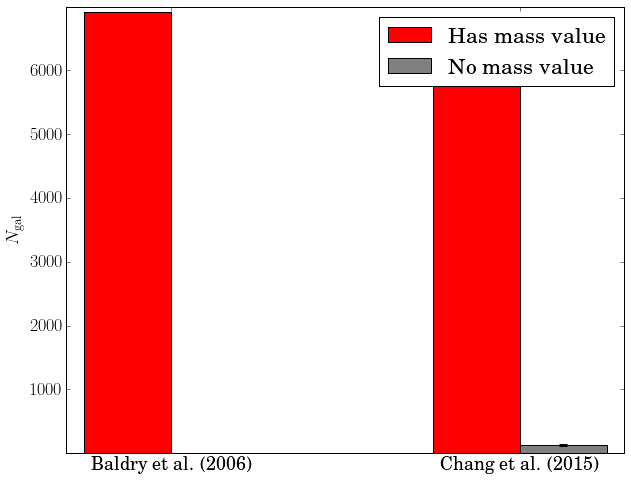

In [15]:
has_baldry_mass = np.isfinite(sample_data['LOGMSTAR_BALDRY06'])
has_chang_mass = sample_chang_out['lmass50_all'] > -999

has_mass = Table()
has_mass['Baldry et al. (2006)'] = [np.sum(has_baldry_mass), np.sum(has_baldry_mass == False)]
has_mass['Chang et al. (2015)'] = [np.sum(has_chang_mass), np.sum(has_chang_mass == False)]

_ = comparison_bar_chart(has_mass,['Has mass value','No mass value'],['r','grey'],linewidth=1,ylabel='$N_\mathrm{gal}$')

In [176]:
# firstly, simply focus on the luminosity in each filter?

def reduce_datasets(mask):
    
    data_masked = data[mask]
    nsa_masked = nsa[mask]
    mpa_i_masked = mpa_i[mask]
    mpa_masses_masked = mpa_masses[mask]
    mpa_sfrs_masked = mpa_sfrs[mask]
    chang_in_masked = chang_input[mask]
    chang_out_masked = chang_output[mask]
    
    return (data_masked,nsa_masked,mpa_i_masked,mpa_masses_masked,
            mpa_sfrs_masked,chang_in_masked,chang_out_masked)

In [177]:
in_sample = (data['in_volume_limit']) & (data['in_mass_limit']) & (data['in_spiral']) # in mass-limited spiral sample
# stellar mass-limited samples:
ml_data, ml_nsa, ml_mpa_i, ml_mpa_masses, ml_mpa_sfrs, ml_chang_in, ml_chang_out = reduce_datasets(in_sample)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


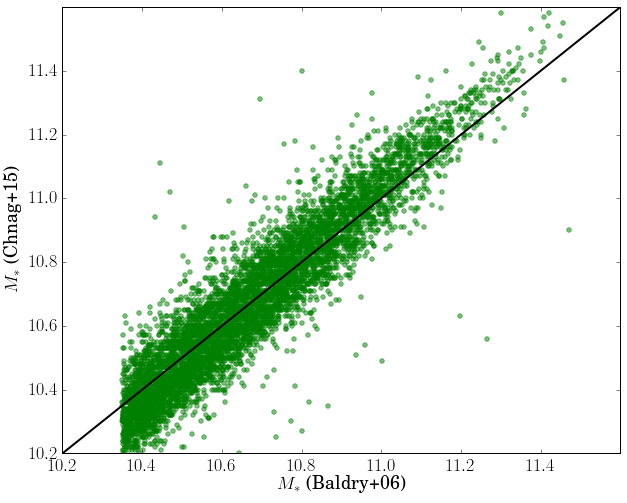

In [191]:
# Compare mass estimates:

_ = plt.scatter(ml_data['baldry06_chabrier_mass'],ml_chang_out['lmass50_all'],alpha=0.5,color='g')
plt.axis((10.2,11.6,10.2,11.6))
plt.plot([10.2,11.6],[10.2,11.6],'k-',lw=2)
plt.xlabel('$M_*$ (Baldry+06)')
plt.ylabel('$M_*$ (Chnag+15)')

In [367]:
def stack_histogram(x,m_values,bins,reference='all',xlabel='x',ylabel='normalised \n density'):
    
    fig,axarr = plt.subplots(5,1,figsize=(10,15),sharex=True,sharey=True)
    plt.subplots_adjust(hspace=0,wspace=0)
    colors_long = ['orange','r','m','g','b','k','y']
    labels = ['1','2','3','4','5+']
    if reference != 'all':
        x_ref = x[reference]
    else:
        x_ref = x
    
    ymax = []
    
    for m in range(5):
        x_m = x[m_values == m]
        axarr[m].hist(x_ref,bins=bins,color='k',alpha=0.4,histtype='stepfilled',normed=True)
        _ = axarr[m].hist(x_m,bins=bins,color=colors_long[m],lw=3,histtype='step',normed=True)
        axarr[m].set_ylabel(ylabel)
        ymax.append(np.max(_[0]))
        axarr[m].text(0.975,0.925,'m={}: {} galaxies'.format(labels[m],len(x_m)),
                     transform=axarr[m].transAxes,ha='right',va='top')
    axarr[-1].set_xlabel(xlabel)
    axarr[-1].set_ylim(0,np.round(np.max(ymax)*1.5,decimals=1))
    
    return None


def plot_sfrs_and_ssfrs(sfrs,masses,sfr_masks,mass_masks,m_values,xlabels):
    
    mass_list = [np.ones(len(sfrs[0]))]
    mass_mask_list = [np.full(len(sfrs[0]),True,dtype='bool')]
    for mass in masses:
        mass_list.append(mass)
    for mass_mask in mass_masks:
        mass_mask_list.append(mass_mask)
    masses = mass_list
    mass_masks = mass_mask_list
    
    i = 0
    
    for s,sfr in enumerate(sfrs):
        sfr_mask = sfr_masks[s]
        for M,mass in enumerate(masses):
            mass_mask = mass_masks[M]
            
            combined_mask = (mass_mask) & (sfr_mask)
            x = np.log10(10**(sfr)/10**(mass))[combined_mask]
            bins = np.linspace(np.min(x[np.isfinite(x)]),np.max(x[np.isfinite(x)]),21)
            bin_range = [np.percentile(x[np.isfinite(x)],1,interpolation='nearest')
                         ,np.percentile(x[np.isfinite(x)],99,interpolation='nearest')]
            bins = np.linspace(bin_range[0],bin_range[1],21)
            m_masked = m_values[combined_mask]
            stack_histogram(x,m_masked,xlabel=xlabels[i],bins=bins)
            i = i+1
            plt.savefig('output_figures/hist_{}.pdf'.format(i))
    
    return None

In [355]:
fuv_lum = Mag_to_lum(ml_nsa['ABSMAG'][:,0])
log_fuv_lum = np.log10(FUV_lum)

baldry_mass = ml_data['baldry06_chabrier_mass']
chang_mass = ml_chang_out['lmass50_all']

chang_sfr = ml_chang_out['lsfr50_all']
mpa_sfr = ml_mpa_sfrs['AVG']

# create individual masks:

baldry_mass_mask = baldry_mass > 0
chang_mass_mask = chang_mass > 0

chang_sfr_mask = chang_sfr > -10
mpa_sfr_mask = mpa_sfr > -10
fuv_lum_mask = np.isfinite(fuv_lum) & (log_fuv_lum > 5)

sfrs = [chang_sfr,mpa_sfr,log_fuv_lum]
sfr_masks = [chang_sfr_mask,mpa_sfr_mask,fuv_lum_mask]

masses = [baldry_mass,chang_mass]
mass_masks = [baldry_mass_mask,chang_mass_mask]

m_values = ml_data['m']

/home/ppxrh/Github_repos/astro_codes/magnitude_conversions.py:8: RuntimeWarning: overflow encountered in power
  lum = 10**((M_sun-Mag)/2.5)


In [368]:
xlabels = ['SFR (WISE)','sSFR (WISE, Baldry+ mass)','sSFR (WISE,Chang+ mass)',
           'SFR (MPA-JHU)','sSFR (MPA-JHU, Baldry+ mass)','sSFR (MPA-JHU, Chang+ mass)',
           'FUV luminosity', 'normalised FUV luminosity (Baldry+ mass)', 'normalised FUV luminosity (Chang+ mass)']

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in true_divide
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in true_divide
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in true_divide
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:47: RuntimeWarni

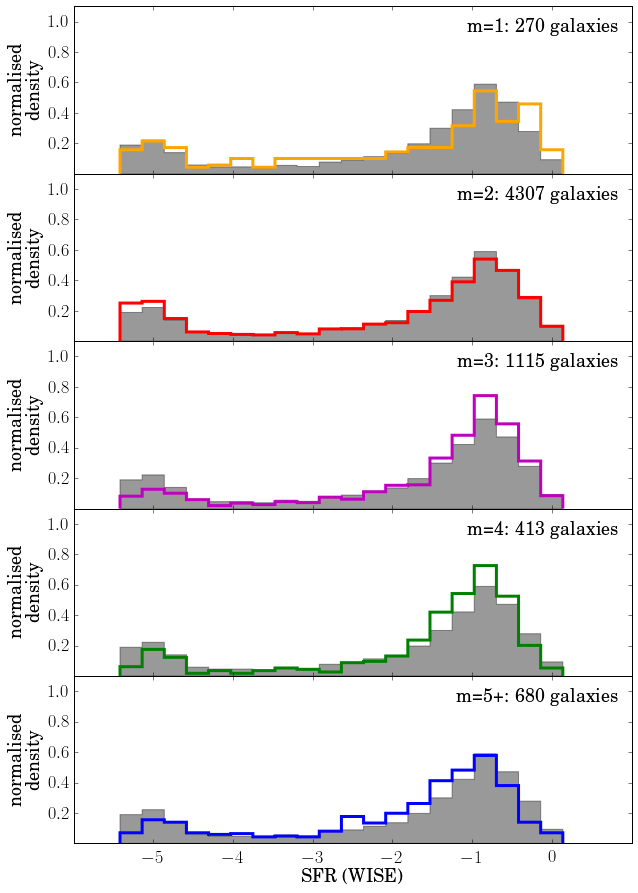

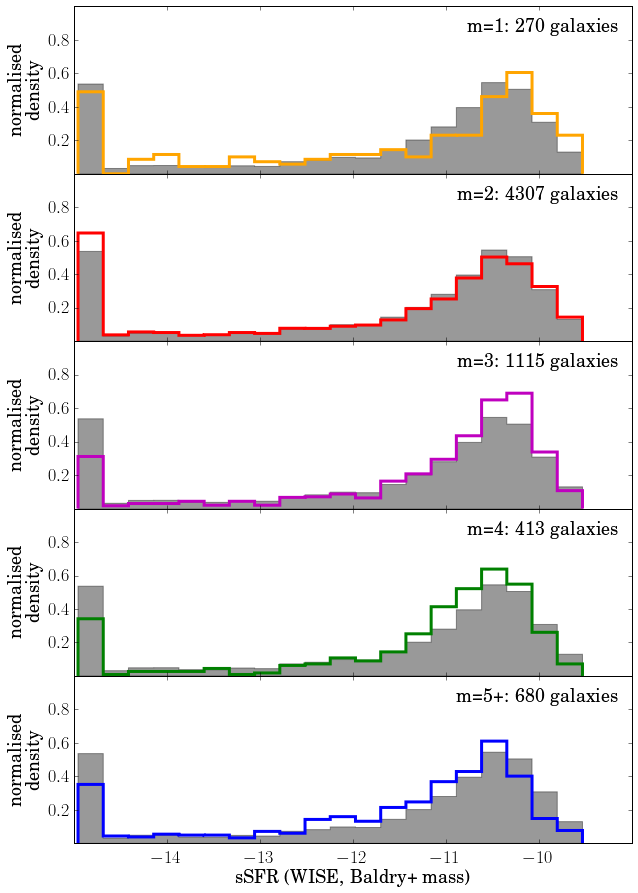

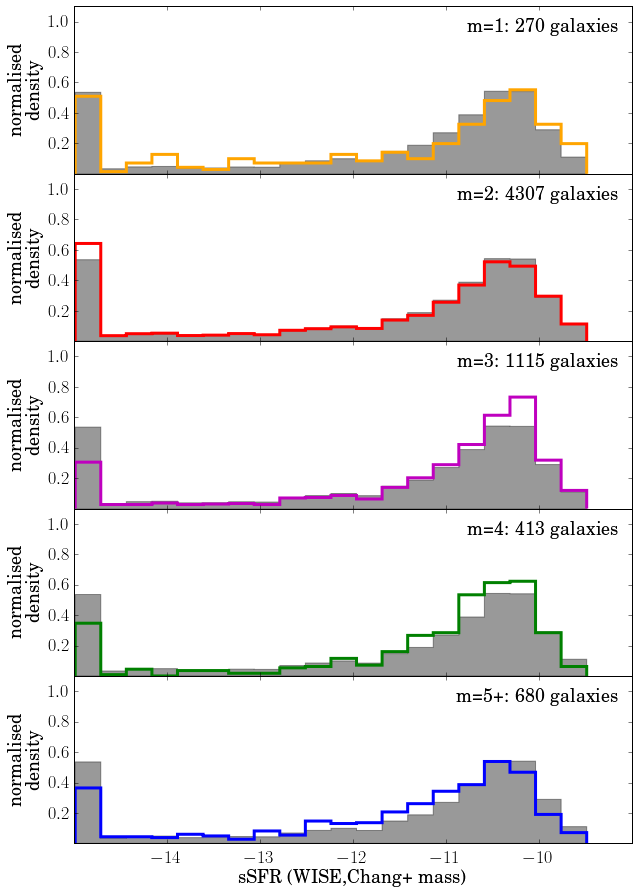

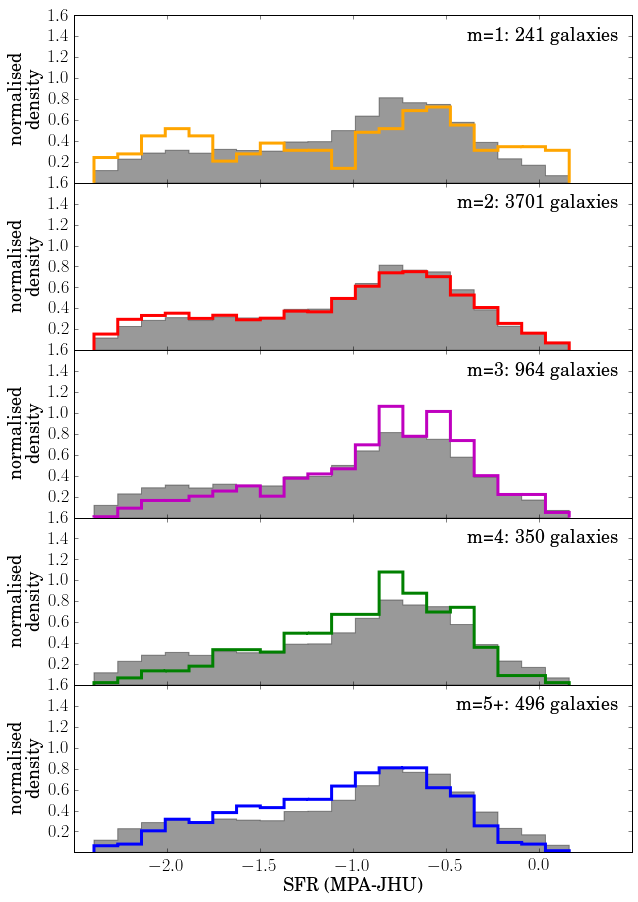

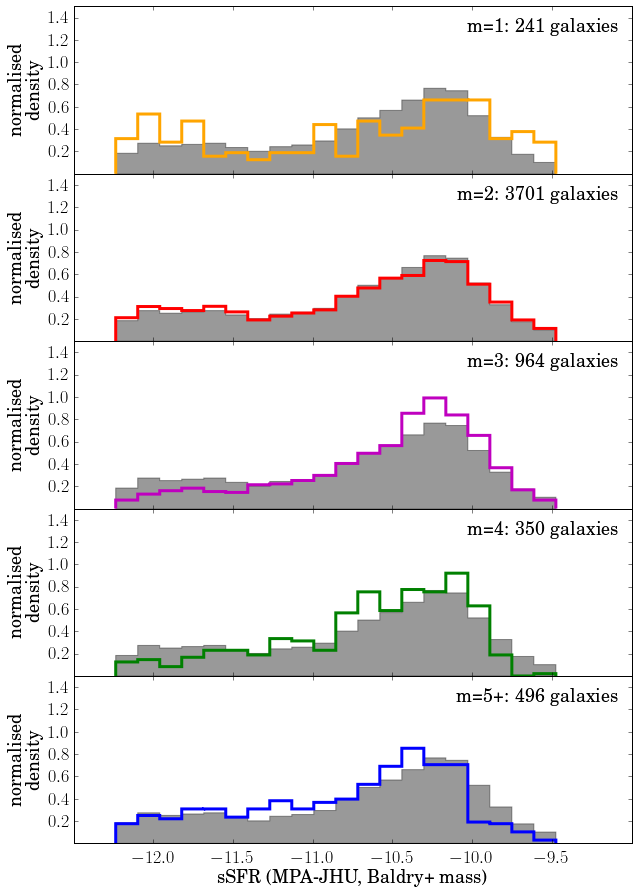

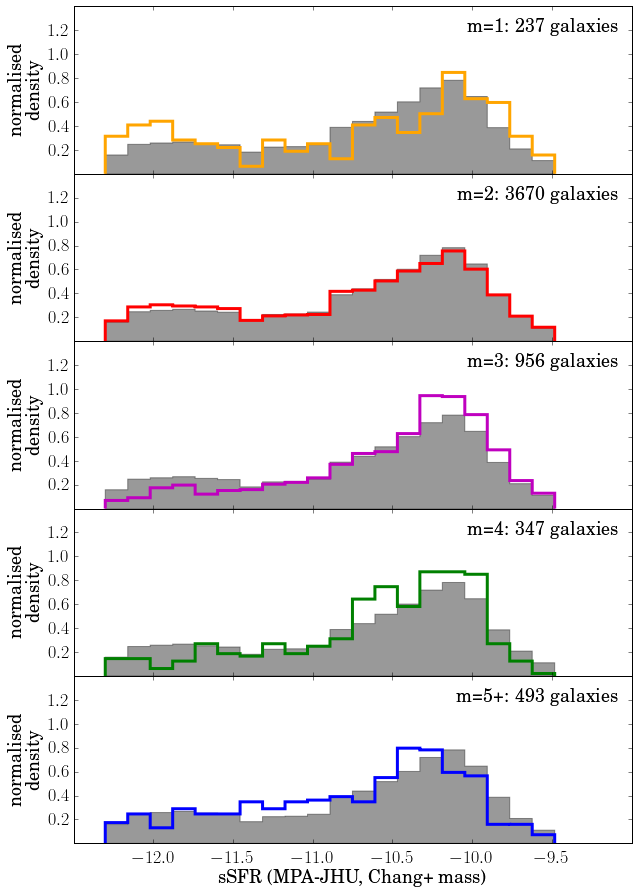

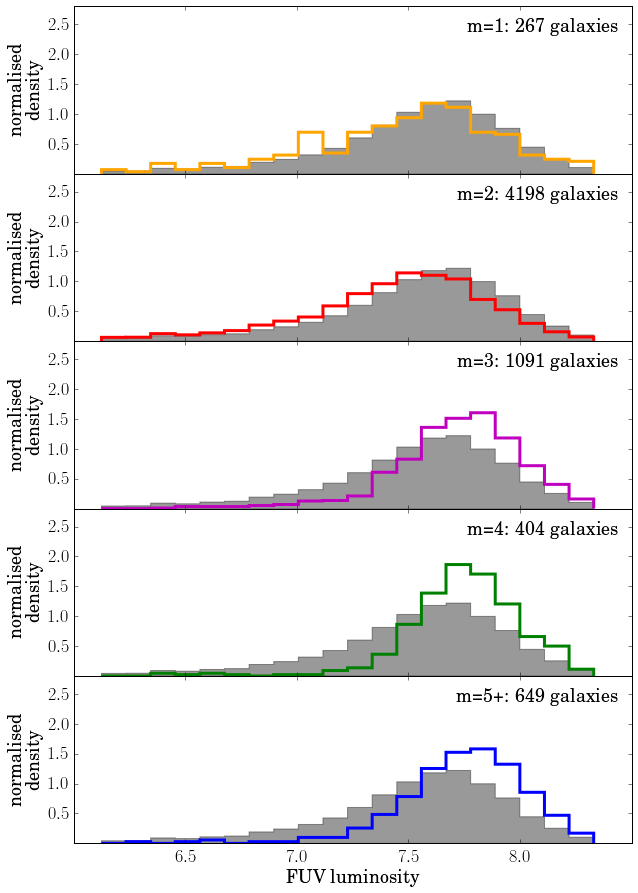

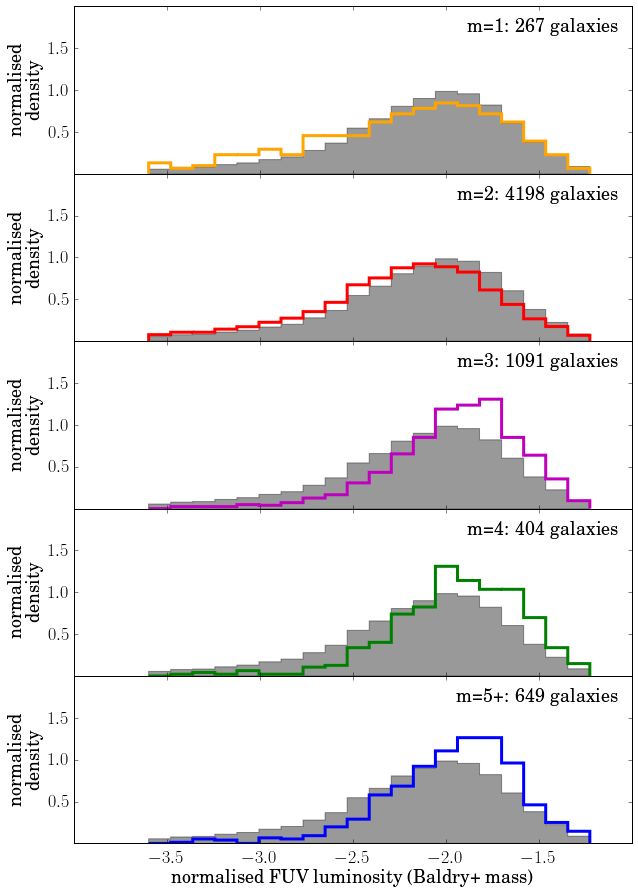

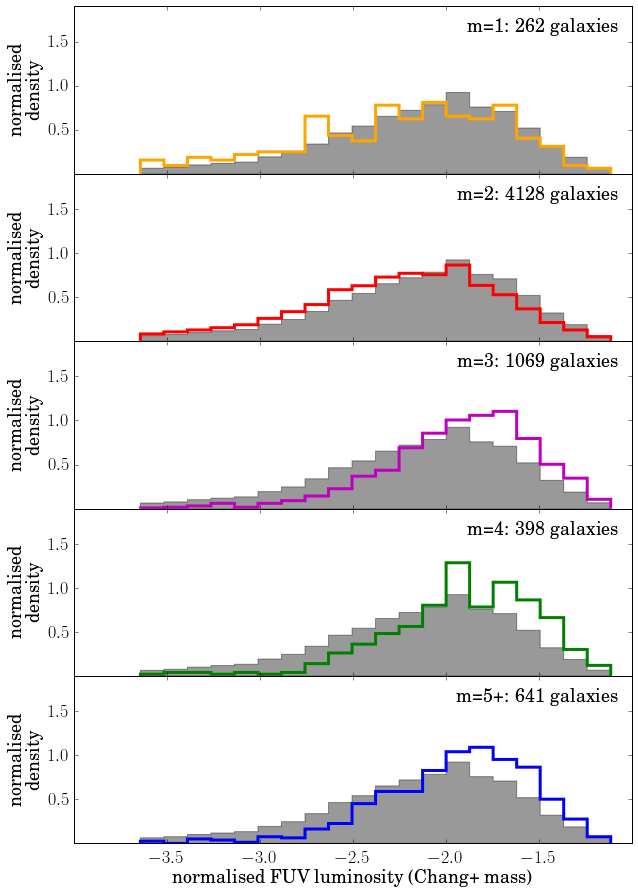

In [369]:
_ = plot_sfrs_and_ssfrs(sfrs,masses,sfr_masks,mass_masks,m_values,xlabels)

In [411]:
def get_chang_mask(data):
    
    flags = ['flag_w','flag_w1','flag_w2','flag_w3','flag_w4']
    
    detections = Table()
    
    for flag in flags:
        has_detection = data[flag] == 1
        detections[flag] = has_detection
    
    return detections


def get_nsa_mask(data):
    
    detections = Table()
    
    error_column = data['AMIVAR']
    detections['has_match'] = data['mask'] == True
    labels = 'FNugriz'
    for c in range(7):
        has_filter = error_column[:,c] != 0
        detections[labels[c]] = has_filter
        
    return detections

5 4


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


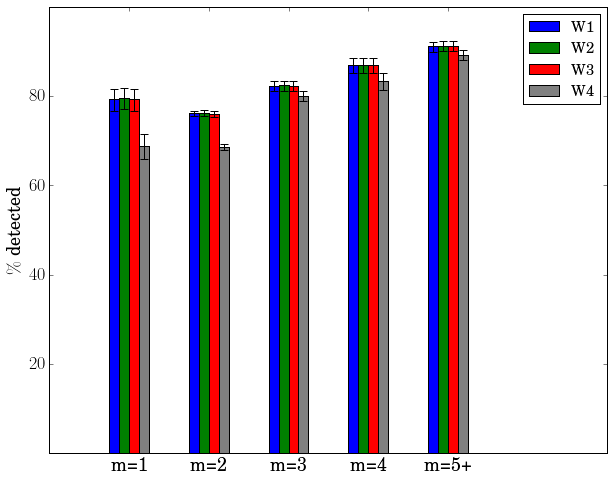

In [443]:
detections = get_chang_mask(ml_chang_out)

labels = ['1','2','3','4','5+']
has_detection_wise = Table()
t = []

for m in range(5):
    
    m_select = ml_data['m'] == m
    t.append(np.sum(m_select))
    w_detections = []
    
    for w in range(4):
    
        w_detections.append(np.sum((detections['flag_w'][m_select]) 
                                   & (detections['flag_w{}'.format(w+1)][m_select])))
        
    has_detection_wise['m={}'.format(labels[m])] = w_detections

_ = comparison_bar_chart(has_detection_wise,['W1','W2','W3','W4'],colors=['b','g','r','gray']
                         ,normalise='percent',column_totals=t,linewidth=1,ylabel='$\%$ detected')

5 2


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


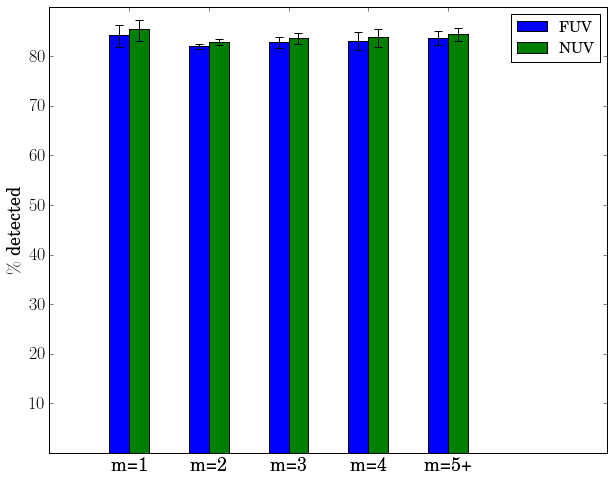

In [446]:
detections = get_nsa_mask(ml_nsa)

t = []
uv_labels = 'FNugriz'
has_detection_nsa = Table()

for m in range(5):
    
    m_select = ml_data['m'] == m
    t.append(np.sum(m_select))
    uv_detections = []
    
    for uv in range(2):
    
        uv_detections.append(np.sum((detections['has_match'][m_select]) 
                                   & (detections[uv_labels[uv]][m_select])))
        
    has_detection_nsa['m={}'.format(labels[m])] = uv_detections
    
_ = comparison_bar_chart(has_detection_nsa,['FUV','NUV'],colors='bg'
                         ,normalise='percent',column_totals=t,linewidth=1,ylabel='$\%$ detected')

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


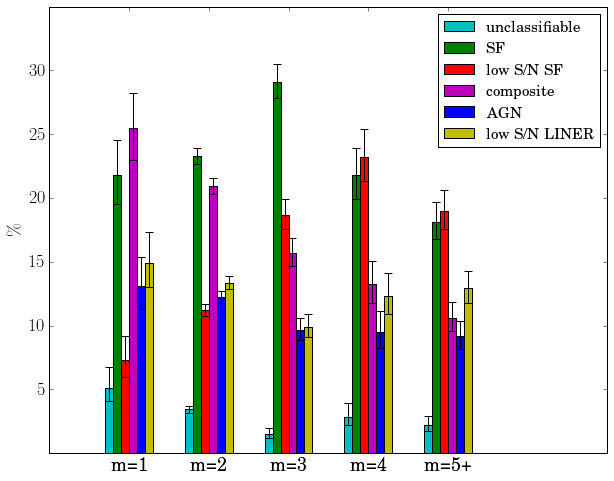

In [466]:
# what SF category does each galaxy get from the MPA-JHU catalogue?

t = []
i_class_fractions = Table()
class_names = ['unclassifiable','SF','low S/N SF','composite','AGN','low S/N LINER']

for m in range(5):
    
    m_select = ml_data['m'] == m
    t.append(np.sum(m_select))
    N_class = []
    
    for class_value in [-1,1,2,3,4,5]:
        N_class.append(np.sum(ml_mpa_i['I_CLASS'][m_select] == class_value))
    
    i_class_fractions['m={}'.format(labels[m])] = N_class
    
_ = comparison_bar_chart(i_class_fractions,class_names,colors='cgrmby',width=0.6
                         ,normalise='percent',column_totals=t,linewidth=1,ylabel='$\%$')